<a href="https://colab.research.google.com/github/p3dr0id/bayesian_inference_commodities/blob/main/bayesian_inferece_commodities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando pacotes necessários...
Iniciando pipeline de análise...
Os resultados serão salvos em: /content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/analise_final_tcc/resultado 04/
Etapa 1: Carregando dados...
Carregando dados de grao de /content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/protofase/SojaFuturoRollover_MACROTRENDS.csv
Dados de grao carregados: 14189 registros
Carregando dados de farelo de /content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/protofase/FareloFuturoRollover-1979-2025 - FareloFuturoRollover-1979-1999.csv
Dados de farelo carregados: 11461 registros
Carregando dados de oleo de /content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/protofase/OleoSojaFuturoRollover_MACROTRENDS - OleoSojaFuturoRollover_MACROTRENDS.csv
Dado

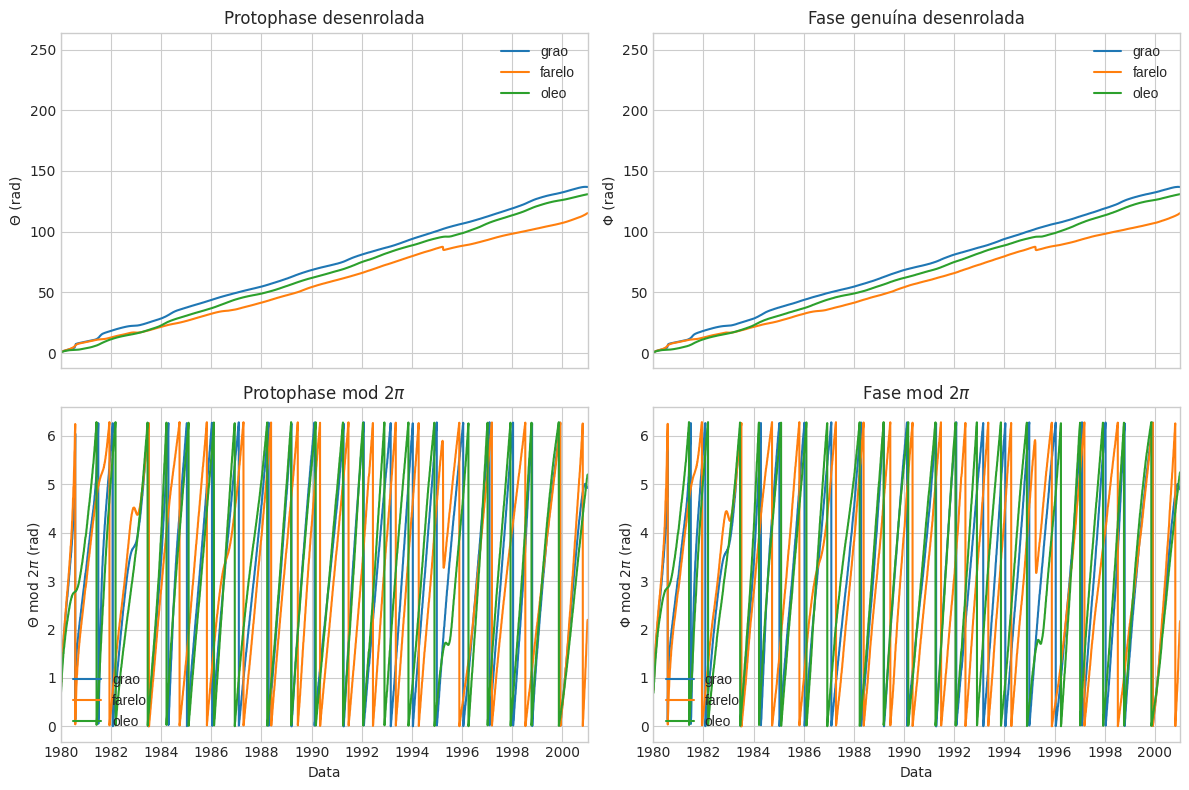

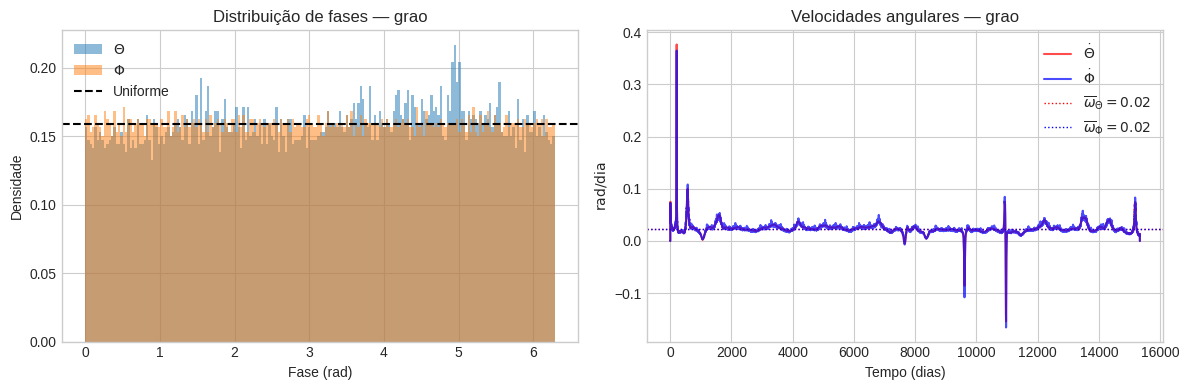

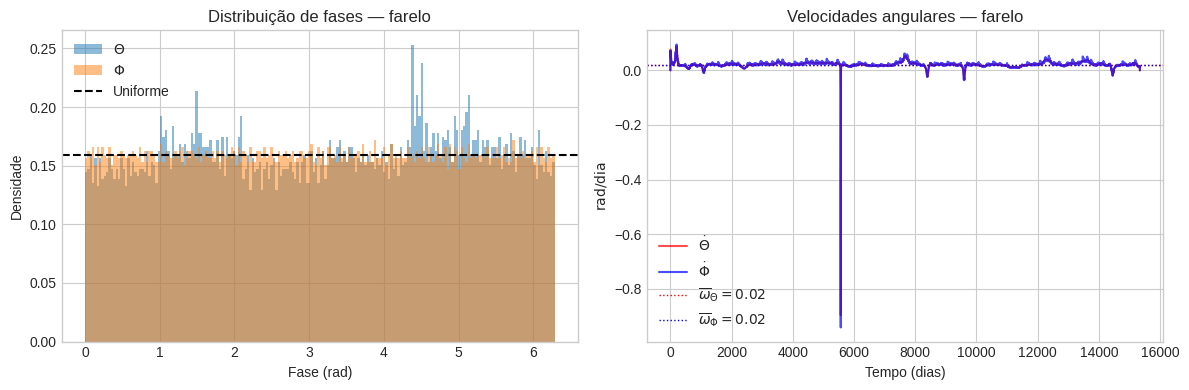

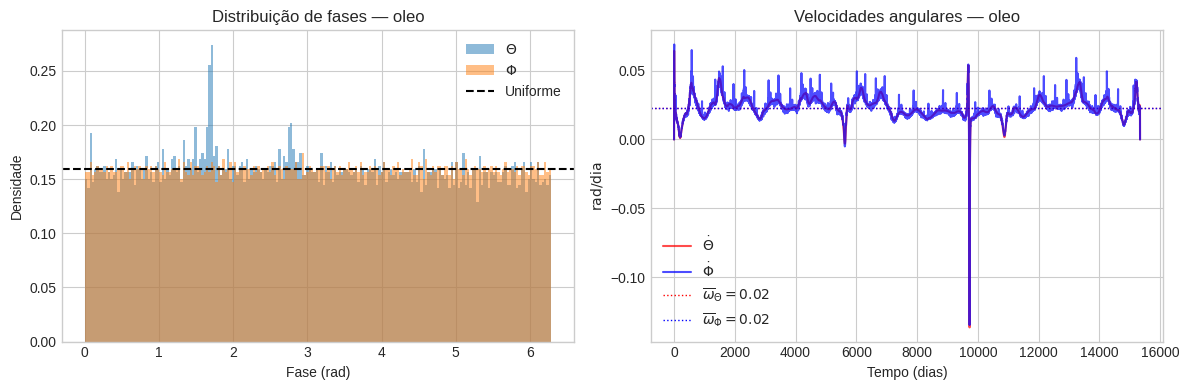

Etapa 5: Analisando sistema acoplado...
Ruído estimado: [2.e-05 2.e-05 2.e-05]
Etapa 6: Otimizando parâmetros de inferência...
Iniciando grid-search com 1000 combinações...
Melhor combinação: pw=0.1, window=175.0, step=15.0, score=0.1807

Top 5 combinações:
       pw  window_size  step_size     score
130  0.10          175         15  0.180745
330  0.15          175         15  0.180176
530  0.20          175         15  0.180173
730  0.25          175         15  0.180170
930  0.30          175         15  0.180168
Etapa 7: Executando inferência com parâmetros ótimos...
Figura de parâmetros salva em: /content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/analise_final_tcc/resultado 04/inferred_parameters.png
Etapa 8: Simulando modelo com seleção de seed...
Seed 0: Novo melhor score = -1.2842 (Δr=0.0819, NRMSE=3.1711 ciclos, Corr=-0.0312)
Seed 1: Novo melhor score = -1.1624 (Δr=0.0641, NRMSE=3.1059 ciclos, Corr=0.0075)
Seed 3: 

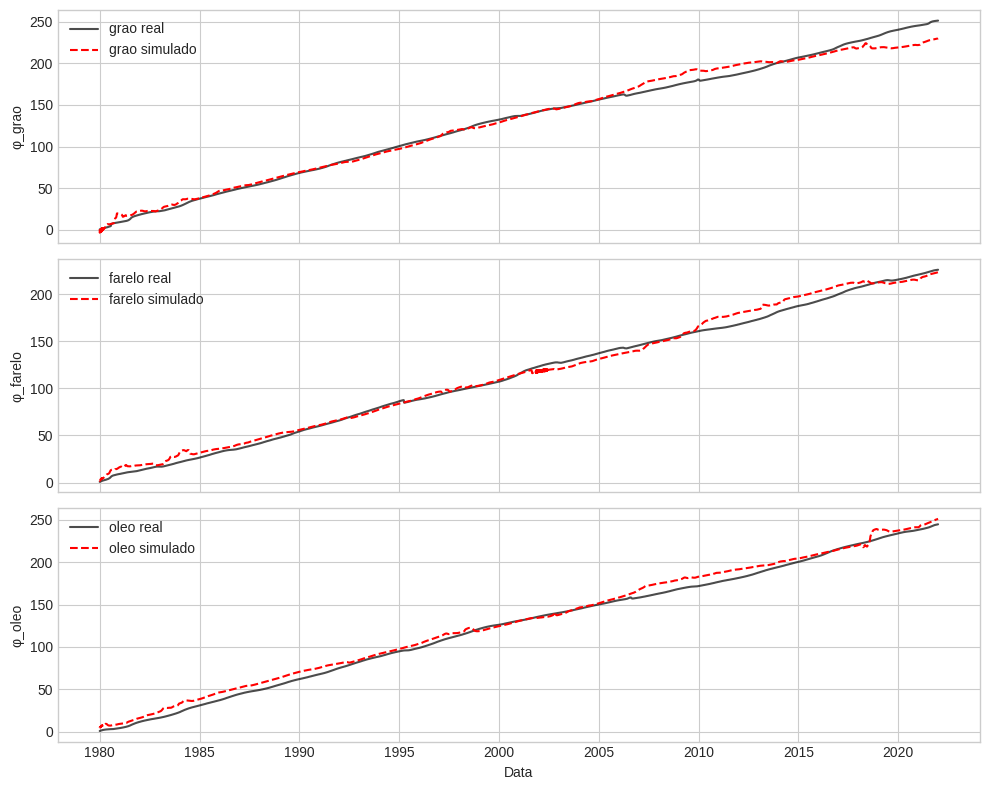

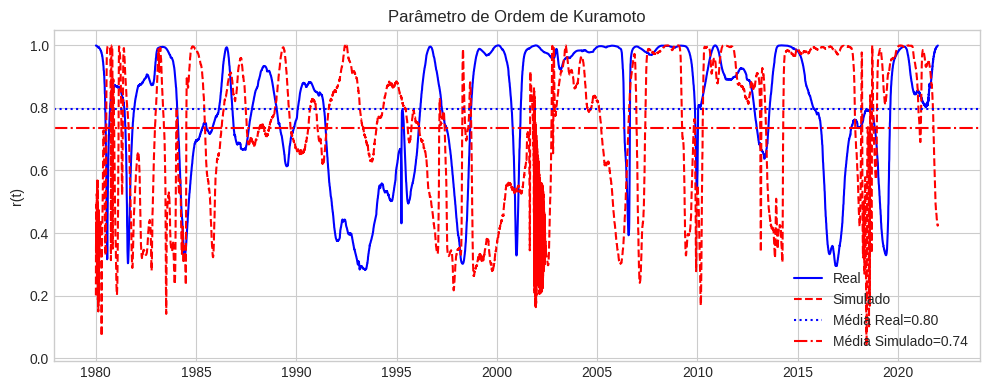

Etapa 9: Gerando relatório final...

    ============= RELATÓRIO DE ANÁLISE =============
    | Métrica                     | Valor        |
    |-----------------------------|--------------|
    | Seed ótimo                  | 21  |
    | Diferença média no parâmetro| 0.0608|
    | NRMSE (frações de ciclo)    | 1.069824 |
    | Correlação de Frequência    | 0.026179 |
    | Média r_real                | 0.7975 |
    | Média r_sim                 | 0.7367 |

    === Parâmetros de Inferência Ótimos ===
    pw = 0.100
    window_size = 175
    step_size = 15

    === Resumo dos Parâmetros Inferidos ===
        Oscillator Parameter True Value  Inferred Mean  Inferred Std  Significância
0            1        ω1        N/A         0.0145        0.0286           0.51
1            1       A11        N/A        -0.0058        0.0387           0.15
2            1       A12        N/A        -0.0013        0.0250           0.05
3            1       A13        N/A         0.0042        0.0245    

In [ ]:
# -*- coding: utf-8 -*-


# ===================== CONFIGURAÇÕES GERAIS =====================

print("Instalando pacotes necessários...")
!pip install --quiet dynabayes scikit-optimize emd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from scipy.signal import hilbert, coherence
from scipy.interpolate import interp1d
from scipy.stats import entropy, wasserstein_distance
import emd
import dynabayes as db
from dynabayes.utils import generate_param_names
import itertools
from joblib import Parallel, delayed
import matplotlib as mpl
import os  # Adicionado para manipulação de caminhos

# Configurar fonte para evitar warnings de glifos faltantes
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Configurações globais
CONFIG = {
    'sample_rate': 252,       # Dias úteis por ano
    'max_imfs': 9,            # Máximo de IMFs a extrair
    'n_harm': 500,            # Número de harmônicos para conversão de fase
    'z_thresh': 2.0,          # Limiar para corte de outliers
    'trim_pct': 5,            # Percentil para estimativa de ruído
    'target_freq': 1.0,       # Frequência alvo para seleção de IMF (ciclos/ano)
    'freq_tol': 0.3,          # Tolerância para seleção de IMF
    'output_path': '/content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/analise_final_tcc/resultado 04/'  # Novo parâmetro
}

# ===================== FUNÇÕES AUXILIARES =====================

def get_output_path(filename):
    """Retorna o caminho completo para salvar arquivos"""
    # Criar diretório se não existir
    os.makedirs(CONFIG['output_path'], exist_ok=True)
    return os.path.join(CONFIG['output_path'], filename)

def load_financial_data(urls, config):
    """Carrega dados financeiros de múltiplas fontes e faz merge."""
    series = []
    for name, (url, date_col, value_col, date_format) in urls.items():
        try:
            print(f"Carregando dados de {name} de {url}")
            df_temp = pd.read_csv(
                url,
                parse_dates=[date_col],
                date_format=date_format
            )
            s = df_temp.set_index(date_col)[value_col].rename(name)
            series.append(s)
            print(f"Dados de {name} carregados: {len(s)} registros")
        except Exception as e:
            print(f"Erro ao carregar {name} de {url}: {str(e)}")
            raise

    # Concatena e filtra datas comuns
    print("Concatenando séries temporais...")
    df = pd.concat(series, axis=1, join='inner').dropna()
    df.index.name = 'date'

    # Remove anos incompletos
    print("Filtrando anos incompletos...")
    year_counts = df.index.year.value_counts()
    complete_years = year_counts[year_counts >= 0.9 * CONFIG['sample_rate']].index
    df = df[df.index.year.isin(complete_years)]

    print(f"Dataset final: {df.shape[0]} registros, {df.shape[1]} séries")
    return df

def summarize_imfs(data, sample_rate=252, max_imfs=9):
    """Extrai IMFs via EMD e retorna estatísticas médias."""
    imf = emd.sift.mask_sift(data, max_imfs=max_imfs)
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    freq_med = IF.mean(axis=0)
    T_med = 1.0 / freq_med
    A_med = IA.mean(axis=0)

    df = pd.DataFrame({
        'F_med (ciclos/ano)': np.round(freq_med, 1),
        'T_med (ano)': np.round(T_med, 1),
        'T_med (dias)': np.round(sample_rate * T_med, 0).astype(int),
        'A_med': np.round(A_med, 2)
    }, index=np.arange(1, len(freq_med)+1))

    df.index.name = 'N_IMF'
    return df

def select_imf_by_frequency(series, target_freq=1.0, tol=0.3):
    """Seleciona IMF com frequência mais próxima do alvo."""
    stats = summarize_imfs(series.values, CONFIG['sample_rate'], CONFIG['max_imfs'])
    freqs = stats['F_med (ciclos/ano)']
    closest_idx = np.argmin(np.abs(freqs - target_freq))
    diff = np.abs(freqs.iloc[closest_idx] - target_freq)

    if diff > tol:
        print(f"Aviso: Nenhuma IMF próxima de {target_freq}±{tol} ciclos/ano. "
              f"Melhor: IMF{closest_idx+1} com {freqs.iloc[closest_idx]} ciclos/ano")

    return closest_idx + 1  # Índice 1-based

def compute_protofase_hilbert(Y):
    """Protophase desenrolada via transformada de Hilbert."""
    return np.unwrap(np.angle(hilbert(Y - np.mean(Y))))

def compute_protofase_hilbert_huang(Y, imf_index, sample_rate=252, max_imfs=9):
    """Protophase a partir da IMF escolhida (1-based) e Hilbert–Huang."""
    imf = emd.sift.mask_sift(Y, max_imfs=max_imfs)
    IP, _, _ = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    return np.unwrap(IP[:, imf_index-1])

def protophase_to_phase(phi_pro, N_harm=200, method='cdf'):
    """
    Mapeia protophase → fase genuína desenrolada usando dois métodos:
      'fourier': Expansão harmônica (Eq. 16 do artigo)
      'cdf': Transformação cumulativa (distribuição uniforme)
    """
    if method == 'fourier':
        S = np.array([np.mean(np.exp(-1j * n * phi_pro)) for n in range(1, N_harm + 1)])
        phi = phi_pro.copy()
        for n, Sn in enumerate(S, start=1):
            phi += 2 * np.imag(Sn * (np.exp(1j * n * phi_pro) - 1)) / n
        #phi = np.unwrap(phi)

    elif method == 'cdf':
        θ_wrapped = phi_pro % (2*np.pi)
        hist, bin_edges = np.histogram(θ_wrapped, bins=360, range=(0, 2*np.pi))
        cdf = np.cumsum(hist) / len(θ_wrapped)
        bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

        cdf_interp = interp1d(
            np.hstack([0, bin_centers, 2*np.pi]),
            np.hstack([0, cdf, 1]),
            kind='linear'
        )

        φ_wrapped = 2*np.pi * cdf_interp(θ_wrapped)
        k_cycles = (phi_pro - θ_wrapped) / (2*np.pi)
        phi = φ_wrapped + 2*np.pi * k_cycles

    else:
        raise ValueError("Método inválido. Use 'fourier' ou 'cdf'")

    return phi

def validate_phase(phase):
    """Verifica propriedades fundamentais da fase."""
    diff = np.diff(phase)
    monotonic = np.all(diff >= 0)
    avg_slope = np.mean(diff)
    var_slope = np.var(diff)

    metrics = {
        'monotonic': monotonic,
        'avg_slope': avg_slope,
        'var_slope': var_slope,
        'n_decreases': np.sum(diff < 0)
    }

    if not monotonic:
        print(f"Aviso: Fase não monotônica! {metrics['n_decreases']} decréscimos detectados.")

    return metrics

def estimate_noise_from_phase(phi_array, dt, trim_pct=5):
    """Estima variação de ruído E_i a partir das velocidades instantâneas das fases."""
    E_est = []
    for w in np.gradient(phi_array, dt, axis=1):
        resid = w - w.mean()
        lo, hi = np.percentile(resid, [trim_pct, 100-trim_pct])
        mask = (resid >= lo) & (resid <= hi)
        E_est.append(np.var(resid[mask]) * dt)
    return E_est

def plot_phase_panels(dates, thetas, phis, year_start=None, year_end=None, tick_interval=1):
    """Plota 2×2 subplots de protophase/fase desenrolada e módulo 2π."""
    fig, axs = plt.subplots(2,2, figsize=(12,8), sharex=True)
    plt.style.use('seaborn-v0_8-whitegrid')

    for name, θ in thetas.items():
        axs[0,0].plot(dates, θ, label=name)
    axs[0,0].set(title='Protophase desenrolada', ylabel='Θ (rad)')
    axs[0,0].legend(); axs[0,0].grid(True)

    for name, φ in phis.items():
        axs[0,1].plot(dates, φ, label=name)
    axs[0,1].set(title='Fase genuína desenrolada', ylabel='Φ (rad)')
    axs[0,1].legend(); axs[0,1].grid(True)

    for name, θ in thetas.items():
        axs[1,0].plot(dates, np.mod(θ,2*np.pi), label=name)
    axs[1,0].set(title='Protophase mod $2\pi$', xlabel='Data', ylabel='Θ mod $2\pi$ (rad)')
    axs[1,0].legend(); axs[1,0].grid(True)

    for name, φ in phis.items():
        axs[1,1].plot(dates, np.mod(φ,2*np.pi), label=name)
    axs[1,1].set(title='Fase mod $2\pi$', xlabel='Data', ylabel='Φ mod $2\pi$ (rad)')
    axs[1,1].legend(); axs[1,1].grid(True)

    if year_start and year_end:
        start = pd.to_datetime(f'{year_start}-01-01')
        end = pd.to_datetime(f'{year_end}-12-31')
        for ax in axs.flatten():
            ax.set_xlim(start, end)

    locator = YearLocator(base=tick_interval)
    formatter = DateFormatter('%Y')
    for ax in axs.flatten():
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    output_path = get_output_path('phase_panels.png')
    plt.savefig(output_path, dpi=300)
    plt.show()

def plot_phase_stats_compact(t, θ, φ, dt, name, bins=50):
    """Plota distribuição de fases e velocidades angulares."""
    θm, φm = np.mod(θ, 2*np.pi), np.mod(φ, 2*np.pi)
    counts_th, edges = np.histogram(θm, bins=bins, density=True)
    counts_ph, _ = np.histogram(φm, bins=edges, density=True)
    centers = 0.5*(edges[:-1] + edges[1:])

    dθ = np.gradient(θ, dt)
    σ = counts_th
    dφ = 2*np.pi * np.interp(θm, centers, σ) * dθ

    ω_th, ω_ph = dθ.mean(), dφ.mean()

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

    ax0.hist(θm, bins=edges, density=True, alpha=0.5, label=r'$\Theta$')
    ax0.hist(φm, bins=edges, density=True, alpha=0.5, label=r'$\Phi$')
    ax0.axhline(1/(2*np.pi), color='k', ls='--', label='Uniforme')
    ax0.set_title(f'Distribuição de fases — {name}')
    ax0.set_xlabel('Fase (rad)')
    ax0.set_ylabel('Densidade')
    ax0.legend()
    ax0.grid(True)

    ax1.plot(t, dθ, 'r', alpha=0.7, label=r'$\dot{\Theta}$')
    ax1.plot(t, dφ, 'b', alpha=0.7, label=r'$\dot{\Phi}$')
    ax1.axhline(ω_th, color='r', ls=':', lw=1,
                label=rf'$\overline{{\omega}}_{{\Theta}}={ω_th:.2f}$')
    ax1.axhline(ω_ph, color='b', ls=':', lw=1,
                label=rf'$\overline{{\omega}}_{{\Phi}}={ω_ph:.2f}$')
    ax1.set_title(f'Velocidades angulares — {name}')
    ax1.set_xlabel('Tempo (dias)')
    ax1.set_ylabel(r'$\mathrm{rad}/\mathrm{dia}$')
    ax1.legend()
    ax1.grid(True)

    plt.tight_layout()
    output_path = get_output_path(f'phase_stats_{name}.png')
    plt.savefig(output_path, dpi=300)
    plt.show()

def compute_trimmed_stats(param_seq, z_thresh=2.0):
    """Trim por z‐score e retorna mean/std de cada coeficiente."""
    μ0 = param_seq.mean(axis=0)
    σ0 = param_seq.std(axis=0)
    μt = np.zeros_like(μ0); σt = np.zeros_like(σ0)
    n_wins, n_osc, n_par = param_seq.shape

    for i in range(n_osc):
        for j in range(n_par):
            vals = param_seq[:,i,j]
            m, s = μ0[i,j], σ0[i,j]

            if s < 1e-16:
                kept = vals
            else:
                z = (vals - m) / s
                mask = np.abs(z) <= z_thresh
                kept = vals[mask] if mask.sum() >= 2 else vals

            μt[i,j], σt[i,j] = kept.mean(), kept.std()

    return μt, σt

def _evaluate_combo(phi_array, dt, E_true, t, N_harm, z_thresh, names, combo):
    """Avalia um (pw,window,step) e retorna score médio off‐diag."""
    pw, w, s = combo
    params, centers = db.run_inference(
        phi_array,
        dt=dt,
        E_true=E_true,
        pw=pw,
        t=t,
        window_size=w,
        step_size=s
    )

    mean_p, std_p = compute_trimmed_stats(params, z_thresh=z_thresh)
    sigs = []
    n_osc, n_par = mean_p.shape

    for i in range(n_osc):
        for j in range(n_par):
            pname = names[i][j]
            if pname[0] in ('A','B') and pname[1] != pname[2]:
                m, sig = mean_p[i,j], std_p[i,j]
                if sig > 0:
                    sigs.append(abs(m) / sig)

    score = float(np.mean(sigs)) if sigs else 0.0
    return {'pw': pw, 'window_size': w, 'step_size': s, 'score': score}

def optimize_inference_params(phi_array, dt, E_true,
                             pw_list, window_sizes, step_sizes,
                             t=None, N_harm=200, z_thresh=2.0,
                             max_workers=1):
    """Grid‐search paralelo em (pw,window_size,step_size)."""
    n_osc, _ = phi_array.shape
    names = generate_param_names(n_osc)
    combos = list(itertools.product(pw_list, window_sizes, step_sizes))

    print(f"Iniciando grid-search com {len(combos)} combinações...")

    results = Parallel(n_jobs=max_workers)(
        delayed(_evaluate_combo)(
            phi_array, dt, E_true, t, N_harm, z_thresh, names, c
        ) for c in combos
    )

    df = pd.DataFrame.from_records(results)
    best = df.loc[df['score'].idxmax()]

    print(f"Melhor combinação: pw={best['pw']}, "
          f"window={best['window_size']}, step={best['step_size']}, "
          f"score={best['score']:.4f}")

    return {
        'pw': best['pw'],
        'window_size': int(best['window_size']),
        'step_size': int(best['step_size'])
    }, df

def show_summary_mean_std(param_seq, true_funcs, time_centers, z_thresh=2.0):
    """Retorna DataFrame com mean±std trimmed de cada parâmetro."""
    mean_p, std_p = compute_trimmed_stats(param_seq, z_thresh)
    n_osc, n_par = mean_p.shape
    names = generate_param_names(n_osc)
    rows = []

    for i in range(n_osc):
        for j in range(n_par):
            tv = (round(true_funcs[i][j](time_centers[-1]),4)
                  if true_funcs else 'N/A')
            rows.append([
                i+1,
                names[i][j],
                tv,
                round(mean_p[i,j],4),
                round(std_p[i,j],4),
                round(abs(mean_p[i,j]) / std_p[i,j], 2) if std_p[i,j] > 0 else 0
            ])

    return pd.DataFrame(
        rows,
        columns=['Oscillator','Parameter','True Value',
                 'Inferred Mean','Inferred Std', 'Significância']
    )

def kuramoto_order(phi_array):
    """Calcula r(t) e ψ(t) do parâmetro de ordem de Kuramoto."""
    Z = np.exp(1j*phi_array)
    R = Z.mean(axis=0)
    return np.abs(R), np.angle(R)


def evaluate_simulation(phi_real, phi_sim):
    """Calcula score multiobjetivo para qualidade da simulação"""
    r_real, _ = kuramoto_order(phi_real % (2*np.pi))
    r_sim, _ = kuramoto_order(phi_sim % (2*np.pi))
    r_diff = np.abs(r_real.mean() - r_sim.mean())

    # Calcular RMSE e NRMSE normalizado por ciclo (2π)
    rmse = np.sqrt(np.mean((phi_real - phi_sim)**2))
    nrmse = rmse / (2 * np.pi)  # Fração de um ciclo completo

    dphi_real = np.gradient(phi_real, axis=1)
    dphi_sim = np.gradient(phi_sim, axis=1)
    freq_corr = np.corrcoef(dphi_real.flatten(), dphi_sim.flatten())[0,1]

    score = (1 - r_diff) + (1 - nrmse) + freq_corr
    return score, r_diff, nrmse, freq_corr

def simulate_from_params_centers(params, centers, E, phi_real, t_max, dt=1.0,
                                kind='linear', n_seeds=50):
    """Simula com diferentes seeds e seleciona a melhor"""
    best_score = -np.inf
    best_phi_sim = None
    best_seed = 0

    for seed in range(n_seeds):
        np.random.seed(seed)

        n_wins, n_osc, _ = params.shape
        ω_funcs, A_funcs, B_funcs = [], [], []

        for i in range(n_osc):
            fω = interp1d(centers, params[:,i,0], kind=kind, fill_value='extrapolate')
            ω_funcs.append(lambda t, f=fω: f(t))

            rowA, rowB = [], []
            for j in range(n_osc):
                fA = interp1d(centers, params[:,i,1+j], kind=kind, fill_value='extrapolate')
                rowA.append(lambda t, f=fA: f(t))

                fB = interp1d(centers, params[:,i,1+n_osc+j], kind=kind, fill_value='extrapolate')
                rowB.append(lambda t, f=fB: f(t))

            A_funcs.append(rowA)
            B_funcs.append(rowB)

        φ_sim, tf, t_sim = db.simulate_model(
            ω_funcs, A_funcs, B_funcs, E, t_max=t_max, dt=dt
        )

        # Usar phi_real passado como argumento
        score, r_diff, nrmse, freq_corr = evaluate_simulation(phi_real, φ_sim)

        if score > best_score:
            best_score = score
            best_phi_sim = φ_sim
            best_seed = seed
            print(f"Seed {seed}: Novo melhor score = {score:.4f} "
                  f"(Δr={r_diff:.4f}, NRMSE={nrmse:.4f} ciclos, Corr={freq_corr:.4f})")

    print(f"\nMelhor seed encontrada: {best_seed} com score {best_score:.4f}")
    return best_phi_sim, tf, t_sim, best_seed

def generate_analysis_report(phi_real, phi_sim, df, best_seed, best_cfg, summary_df):
    """Gera relatório consolidado de métricas de desempenho."""
    r_real, _ = kuramoto_order(phi_real % (2*np.pi))
    r_sim, _ = kuramoto_order(phi_sim % (2*np.pi))
    r_diff = np.abs(r_real.mean() - r_sim.mean())

    # Calcular NRMSE normalizado por ciclo (2π)
    rmse = np.sqrt(np.mean((phi_real - phi_sim[:,:len(df)])**2))
    nrmse = rmse / (2 * np.pi)

    dphi_real = np.gradient(phi_real, axis=1)
    dphi_sim = np.gradient(phi_sim[:,:len(df)], axis=1)
    freq_corr = np.corrcoef(dphi_real.flatten(), dphi_sim.flatten())[0,1]

    report = f"""
    ============= RELATÓRIO DE ANÁLISE =============
    | Métrica                     | Valor        |
    |-----------------------------|--------------|
    | Seed ótimo                  | {best_seed}  |
    | Diferença média no parâmetro| {r_diff:.4f}|
    | NRMSE (frações de ciclo)    | {nrmse:.6f} |
    | Correlação de Frequência    | {freq_corr:.6f} |
    | Média r_real                | {r_real.mean():.4f} |
    | Média r_sim                 | {r_sim.mean():.4f} |

    === Parâmetros de Inferência Ótimos ===
    pw = {best_cfg['pw']:.3f}
    window_size = {best_cfg['window_size']}
    step_size = {best_cfg['step_size']}

    === Resumo dos Parâmetros Inferidos ===
    {summary_df.to_string()}
    """

    return report

def custom_plot_parameters(param_seq, true_funcs, time_centers):
    """
    Versão modificada da plot_parameters que salva no caminho configurado
    """
    n_osc, n_params = param_seq.shape[1], param_seq.shape[2]
    names = generate_param_names(n_osc)
    total = n_osc * n_params

    fig, axs = plt.subplots(total, 1, figsize=(10, 2.5 * total), squeeze=False)
    axs = axs.flatten()

    for i in range(n_osc):
        for j in range(n_params):
            idx = i * n_params + j
            axs[idx].set_ylabel(f'{names[i][j]}')

            if true_funcs:
                true_vals = [true_funcs[i][j](t) for t in time_centers]
                axs[idx].plot(time_centers, true_vals, 'k-', label='True')

            axs[idx].plot(time_centers, param_seq[:, i, j], 'r--', label='Inferred')
            axs[idx].legend()
            axs[idx].grid()

    plt.xlabel("Tempo (dias)")
    plt.tight_layout()

    output_path = get_output_path('inferred_parameters.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figura de parâmetros salva em: {output_path}")

    plt.close()  # Fecha a figura para liberar memória


# ===================== PIPELINE PRINCIPAL =====================

def main():
    print("Iniciando pipeline de análise...")
    print(f"Os resultados serão salvos em: {CONFIG['output_path']}")

    # =============== 1. Leitura e Pré-processamento ===============
    print("Etapa 1: Carregando dados...")

    DATA_SOURCES = {
        'grao': (
            "/content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/protofase/SojaFuturoRollover_MACROTRENDS.csv",
            'date', 'value', None
        ),
        'farelo': (
            "/content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/protofase/FareloFuturoRollover-1979-2025 - FareloFuturoRollover-1979-1999.csv",
            'Date', 'Price', '%m/%d/%Y'
        ),
        'oleo': (
            "/content/drive/MyDrive/Pesquisa/Projetos 2024/Física estatística aplicada a séries temporais financeiras/Codes/protofase/OleoSojaFuturoRollover_MACROTRENDS - OleoSojaFuturoRollover_MACROTRENDS.csv",
            'date', 'value', None
        )
    }

    df = load_financial_data(DATA_SOURCES, CONFIG)

    # =============== 2. Análise de IMFs ===============
    print("Etapa 2: Analisando IMFs...")

    imf_selections = {}
    for name, series in df.items():
        print(f"\nProcessando {name}...")
        print(f"IMFs para {name}:")
        imf_stats = summarize_imfs(series.values)
        print(imf_stats)

        imf_idx = select_imf_by_frequency(
            series,
            target_freq=CONFIG['target_freq'],
            tol=CONFIG['freq_tol']
        )
        imf_selections[name] = imf_idx
        print(f"IMF selecionada para {name}: {imf_idx}")
        print('-' * 60)

    # =============== 3. Extração de Fases ===============
    print("Etapa 3: Extraindo fases...")

    thetas, phis = {}, {}
    phase_metrics = {}

    for name in df.columns:
        print(f"Calculando fase para {name}...")

        θ = compute_protofase_hilbert_huang(
            df[name].values,
            imf_index=imf_selections[name]
        )
        thetas[name] = θ

        φ = protophase_to_phase(θ, N_harm=CONFIG['n_harm'], method='fourier')
        phis[name] = φ

        metrics = validate_phase(φ)
        phase_metrics[name] = metrics
        print(f"Métricas de fase para {name}: {metrics}")

    # =============== 4. Visualização ===============
    print("Etapa 4: Gerando visualizações...")

    plot_phase_panels(
        df.index,
        thetas,
        phis,
        year_start=1980,
        year_end=2000,
        tick_interval=2
    )

    t_days = (df.index - df.index[0]).days.values
    for name in df.columns:
        plot_phase_stats_compact(
            t_days,
            thetas[name],
            phis[name],
            dt=1.0,
            name=name,
            bins=200
        )

    # =============== 5. Análise Conjunta ===============
    print("Etapa 5: Analisando sistema acoplado...")

    phi_array = np.vstack([phis[n] for n in df.columns])
    E_true = estimate_noise_from_phase(
        phi_array,
        dt=1.0,
        trim_pct=CONFIG['trim_pct']
    )
    print(f"Ruído estimado: {np.round(E_true, 5)}")

    # =============== 6. Otimização de Parâmetros ===============
    print("Etapa 6: Otimizando parâmetros de inferência...")

    # Configuração com até 1000 combinações (5 x 10 x 20):
    pw_list = np.linspace(0.1, 0.3, 5)  # [0.10, 0.15, 0.20, 0.25, 0.30]
    window_sizes = np.linspace(21, 252, 10, dtype=int)  # Aproximadamente: [21, 46, 72, 98, 124, 149, 175, 201, 226, 252]
    step_sizes = np.arange(5, 25, 1)  # 20 valores [5, 6, ..., 24 dias úteis]




    best_cfg, metrics_df = optimize_inference_params(
        phi_array,
        dt=1.0,
        E_true=E_true,
        pw_list=pw_list,
        window_sizes=window_sizes,
        step_sizes=step_sizes,
        t=t_days,
        N_harm=CONFIG['n_harm'],
        z_thresh=CONFIG['z_thresh'],
        max_workers=8
    )

    print("\nTop 5 combinações:")
    print(metrics_df.sort_values('score', ascending=False).head())

    # =============== 7. Inferência de Parâmetros ===============
    print("Etapa 7: Executando inferência com parâmetros ótimos...")

    params, centers = db.run_inference(
        phi_array,
        dt=1.0,
        E_true=E_true,
        t=t_days,
        **best_cfg
    )

    custom_plot_parameters(params, true_funcs=None, time_centers=centers)

    summary_df = show_summary_mean_std(params, [], centers)

    # =============== 8. Simulação e Validação ===============
    print("Etapa 8: Simulando modelo com seleção de seed...")

    φ_sim, tf, t_sim, best_seed = simulate_from_params_centers(
        params,
        centers,
        E_true,
        phi_array,
        t_max=len(df),
        dt=1.0,
        n_seeds=50
    )

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    for i, name in enumerate(df.columns):
        axs[i].plot(df.index, phi_array[i], 'k-', alpha=0.7, label=f'{name} real')
        axs[i].plot(df.index, φ_sim[i, :len(df)], 'r--', label=f'{name} simulado')
        axs[i].set_ylabel(f'φ_{name}')
        axs[i].legend()
        axs[i].grid(True)

    axs[-1].set_xlabel('Data')
    plt.tight_layout()
    output_path = get_output_path('phase_comparison.png')
    plt.savefig(output_path, dpi=300)
    plt.show()

    r_real, _ = kuramoto_order(phi_array % (2*np.pi))
    r_sim, _ = kuramoto_order(φ_sim % (2*np.pi))

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df.index, r_real, 'b-', label='Real')
    ax.plot(df.index, r_sim, 'r--', label=f'Simulado')
    ax.axhline(r_real.mean(), ls=':', color='b', label=f'Média Real={r_real.mean():.2f}')
    ax.axhline(r_sim.mean(), ls='-.', color='r', label=f'Média Simulado={r_sim.mean():.2f}')
    ax.set(title='Parâmetro de Ordem de Kuramoto', ylabel='r(t)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    output_path = get_output_path('kuramoto_order.png')
    plt.savefig(output_path, dpi=300)
    plt.show()

    # =============== 9. Relatório Final ===============
    print("Etapa 9: Gerando relatório final...")

    report = generate_analysis_report(phi_array, φ_sim, df, best_seed, best_cfg, summary_df)
    print(report)

    output_path = get_output_path('analysis_report.txt')
    with open(output_path, 'w') as f:
        f.write(report)
    print(f"Relatório salvo em: {output_path}")

    print("Pipeline concluído com sucesso!")

if __name__ == "__main__":
    main()